In [79]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy.random as nr

In [80]:
#Sliced MI functions using entropy_KL1 as 1-dimensional entropy estimator
# def project_data(data, theta):
#     return np.expand_dims(theta @ data,axis=0)

# def sliced_MI(dataX, dataY, nMC):
#     dX = dataX.shape[0]
#     dY = dataY.shape[0]
#     MI_slice = np.zeros(nMC)
#     for i in range(nMC):
#         #generate theta, phi
#         vecT = np.random.randn(dX)
#         theta = vecT/np.linalg.norm(vecT)
#         vecP = np.random.randn(dY)
#         phi = vecP/np.linalg.norm(vecP)
#         #Project
#         Xproj = project_data(dataX,theta)
#         Yproj = project_data(dataY,phi)
#         #Estimate sliced MI
#         MI_slice[i] = -entropy_KL1(np.vstack((Xproj, Yproj))) + entropy_KL1(Xproj) + entropy_KL1(Yproj)
        
#     return np.mean(MI_slice), MI_slice


In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F





def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128, cubic=None):
    """Generate samples from a correlated Gaussian distribution."""
    x, eps = torch.chunk(torch.randn(batch_size, 2 * dim), 2, dim=1)
    y = rho * x + torch.sqrt(torch.tensor(1. - rho**2).float()) * eps

    if cubic is not None:
        y = y ** 3

    return x, y

def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Net(nn.Module):
    def __init__(self, nb_states, nb_actions, out_dim, hidden1=400, hidden2=300, init_w=3e-3):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        self.fc2 = nn.Linear(hidden1+nb_actions, hidden2)
        self.fc3 = nn.Linear(hidden2, out_dim)
        self.relu = nn.ReLU()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, xs):
        x, a = xs
        out = self.fc1(x)
        out = self.relu(out)
        # debug()
        out = self.fc2(torch.cat([out,a],1))
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [82]:
import torch


def knn(x, y, k=1, last_only=False, discard_nearest=True):
    """Find k_neighbors-nearest neighbor distances from y for each example in a minibatch x.
    :param x: tensor of shape [T, N]
    :param y: tensor of shape [T', N]
    :param k: the (k_neighbors+1):th nearest neighbor
    :param last_only: use only the last knn vs. all of them
    :param discard_nearest:
    :return: knn distances of shape [T, k_neighbors] or [T, 1] if last_only
    """
    # print(x)
    dist_x = (x ** 2).sum(-1).unsqueeze(1)  # [T, 1]
    dist_y = (y ** 2).sum(-1).unsqueeze(0)  # [1, T']
    cross = - 2 * torch.mm(x, y.transpose(0, 1))  # [T, T']
    distmat = dist_x + cross + dist_y  # distance matrix between all points x, y
    distmat = torch.clamp(distmat, 1e-8, 1e+8)  # can have negatives otherwise!

    if discard_nearest:  # never use the shortest, since it can be the same point
        knn, _ = torch.topk(distmat, k + 1, largest=False)
        knn = knn[:, 1:]
    else:
        knn, _ = torch.topk(distmat, k, largest=False)

    if last_only:
        knn = knn[:, -1:]  # k_neighbors:th distance only

    return torch.sqrt(knn)


def kl_div(x, y, k=1, eps=1e-8, last_only=False):
    """KL divergence estimator for batches x~p(x), y~p(y).
    :param x: prediction; shape [T, N]
    :param y: target; shape [T', N]
    :param k:
    :return: scalar
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x.astype(np.float32))
        y = torch.tensor(y.astype(np.float32))

    nns_xx = knn(x, x, k=k, last_only=last_only, discard_nearest=True)
    nns_xy = knn(x, y, k=k, last_only=last_only, discard_nearest=False)

    divergence = (torch.log(nns_xy + eps) - torch.log(nns_xx + eps)).mean()

    return divergence


def entropy(x, k=1, eps=1e-8, last_only=False):
    """Entropy estimator for batch x~p(x).
        :param x: prediction; shape [T, N]
        :param k:
        :return: scalar
        """
    if type(x) is np.ndarray:
        x = torch.tensor(x.astype(np.float32))

    nns_xx = knn(x, x, k=k, last_only=last_only, discard_nearest=True)

    ent = torch.log(nns_xx + eps).mean() - torch.log(torch.tensor(eps))

    return ent

In [83]:
import numpy as np
import torch
import math
import continuous
from sklearn.neighbors import NearestNeighbors
###



def rand_slices(dim, num_slices,high=10,low=1):
    
    slices = (high - low) * torch.rand((num_slices, dim))+ low
    slices = slices / torch.sqrt(torch.sum(slices ** 2, dim=1, keepdim=True))
    return slices

def arccos_distance_torch(x1, x2, eps=1e-7):
    # x2 = x1 if x2 is None else x2
    
    w1 = x1.norm(p=2, dim=1, keepdim=True)
    
    w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    
    return torch.mean(torch.acos(torch.clamp(torch.abs(torch.matmul(x1, x2.t())/ (w1 * w2.t()).clamp(min=eps)),min=-1+eps,max=1-eps)))

# def cosine_distance_torch(x1, x2=None, eps=1e-7):
#     x2 = x1 if x2 is None else x2
#     w1 = x1.norm(p=2, dim=1, keepdim=True)
#     w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
#     return torch.mean(torch.abs(torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)))

def I_est(X,Y):
    # print('g')
    # return continuous.get_mi(x,y)
    
    return entropy(Y)+entropy(X)-entropy(torch.cat((X,Y),dim=1))
    # return  entropy(x) + entropy(y) -entropy(torch.cat((x,y)))

def DSI (X, Y, num_slices, f1, f2, f1_op, f2_op, omega_X=math.pi/4, omega_Y=math.pi/4, max_iter=700, lam=.5, device="cpu"):
    if isinstance(X, np.ndarray):
        X = torch.tensor(X.astype(np.float32))
    if isinstance(Y, np.ndarray):
        Y = torch.tensor(Y.astype(np.float32))
    embedding_dim_X = X[0].shape[0]
    # print(embedding_dim_X)
    pro_X = rand_slices(embedding_dim_X, num_slices).to(device)
    embedding_dim_Y = Y[0].shape[0]
    pro_Y = rand_slices(embedding_dim_Y, num_slices).to(device)
    with torch.no_grad():
        X_detach = X
        Y_detach = Y
    for _ in range(max_iter):
        projections = f1.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])
        other_proj_X= f1.forward([torch.Tensor(rand_slices(embedding_dim_X, num_slices).to(device)),torch.Tensor(rand_slices(embedding_dim_Y, num_slices).to(device))])
        arccos = arccos_distance_torch(projections, projections)
        # print('arccos_X', arccos)
        
        reg = -lam * (arccos-omega_X)
        encoded_projections_X = torch.matmul((torch.Tensor(projections)), torch.Tensor(X_detach).t())#torch.transpose(torch.Tensor(projections),0,1))
        projections = f2.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])
        other_proj_Y= f2.forward([torch.Tensor(rand_slices(embedding_dim_X, num_slices).to(device)),torch.Tensor(rand_slices(embedding_dim_Y, num_slices).to(device))])
        
        arccos = arccos_distance_torch(projections, projections)#other_proj_Y)
        # print('arccos_Y', arccos)
        reg += -lam * (arccos-omega_Y)
        encoded_projections_Y = torch.matmul((torch.Tensor(projections)), torch.Tensor(Y_detach).t())

        #MI=I_est(np.array([np.array(encoded_projections_X[0])]),np.array([np.array(encoded_projections_Y[0])]))
        MI=I_est(encoded_projections_X,encoded_projections_Y)
        # print(MI)
        
        loss = reg- MI
        f1_op.zero_grad()
        f2_op.zero_grad()
        loss.backward(retain_graph=True)
        f1_op.step()
        f2_op.step()

    projections_X = f1.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])
    projections_Y = f2.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])
    encoded_projections_X = torch.matmul((torch.Tensor(projections_X)), torch.Tensor(X_detach).t())
    encoded_projections_Y = torch.matmul((torch.Tensor(projections_Y)), torch.Tensor(Y_detach).t())


    MI=I_est(encoded_projections_X,encoded_projections_Y)
    

    return MI





#################################################################################################################################
def DSI1 (X, Y, num_slices, f1, f2, f1_op, f2_op, omega_X=math.pi/4, omega_Y=math.pi/4, max_iter=2, lam=.6, lamMI=1., device="cpu"):
    if isinstance(X, np.ndarray):
        X = torch.tensor(X.astype(np.float32))
    if isinstance(Y, np.ndarray):
        Y = torch.tensor(Y.astype(np.float32))
    embedding_dim_X = X[0].shape[0]
    embedding_dim_Y = Y[0].shape[0]
    # print(embedding_dim_X)

    for _ in range(max_iter):

        MI=0
        
        for _ in range(num_slices):
            pro_X=rand_slices(embedding_dim_X, num_slices=1).to(device)
            pro_Y = rand_slices(embedding_dim_Y, num_slices=1).to(device)


            theta=f1.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])
            phi= f2.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])

            X_theta= torch.mm(theta,X.t())

            Y_phi= torch.mm(phi,Y.t())

            # print('m',Y_phi.shape)

            MI+=I_est(X_theta.t(),Y_phi.t())/num_slices
        # print('MIIIII=',MI)


            

        PSI = rand_slices(embedding_dim_X, num_slices).to(device)
        UPSILON = rand_slices(embedding_dim_Y, num_slices).to(device)

        THETA= f1.forward([torch.Tensor(PSI),torch.Tensor(UPSILON)])
        arccosX = arccos_distance_torch(THETA,THETA)

        PHI= f2.forward([torch.Tensor(PSI),torch.Tensor(UPSILON)])
        arccosY = arccos_distance_torch(PHI,PHI)
        

        reg=-lam * (arccosX-omega_X) -lam * (arccosY-omega_Y)
        loss = reg- lamMI*MI
        f1_op.zero_grad()
        f2_op.zero_grad()
        loss.backward(retain_graph=True)
        f1_op.step()
        f2_op.step()
    
    


    MI=0
    for _ in range(num_slices):
        pro_X=rand_slices(embedding_dim_X, num_slices=1).to(device)
        pro_Y = rand_slices(embedding_dim_Y, num_slices=1).to(device)


        theta=f1.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])
        phi= f2.forward([torch.Tensor(pro_X),torch.Tensor(pro_Y)])

        X_theta= torch.mm(theta,X.t())

        Y_phi= torch.mm(phi,Y.t())

        # print('m',Y_phi.shape)

        MI+=I_est(X_theta.t(),Y_phi.t())/num_slices
    

    return MI


In [84]:
#Demo experiment:
#     SMI between subsets of an 5-dimensional standard normal random vector X, specifically SMI(X_{0:3}; X_{1:4})
#     
from torch import optim
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


#Number of slices
nmc = 800
#Maximum dataset size/number of slices to plot
n = 1000
#mags = np.random.rand(15)
mn_est = np.zeros(nmc)
ns = (np.ceil(np.logspace(1, np.log10(n), 5))).astype(int)
val0 = np.zeros((nmc,len(ns)))
val1 = np.zeros((nmc,len(ns)))
val2 = np.zeros((nmc,len(ns)))
for j in range(1):
    # data = np.random.randn(10, n)
    # X = data[0:4,:]
    
    # # print( X[0].shape[0])
    # Y =  data[2:6,:] #np.random.normal(40, n)

    X = nr.normal(0,1,[100,1])
    Y = nr.normal(0,1,[100,1])
    
    
    transform_net_1 = Net(X[0].shape[0],Y[0].shape[0],X[0].shape[0]).to(device)
    op_trannet_1 = optim.Adam(transform_net_1.parameters(), lr=0.005, betas=(0.5, 0.999))
    transform_net_2 = Net(X[0].shape[0],Y[0].shape[0],Y[0].shape[0]).to(device)
    op_trannet_2 = optim.Adam(transform_net_2.parameters(), lr=0.005, betas=(0.5, 0.999))
    # print(torch.acos(torch.Tensor([1.0])))
    print('HAHAHA')
    # print('DSIDSI=', DSI1(X,Y, nmc, transform_net_1, transform_net_2, op_trannet_1,op_trannet_2, device=device).item())
    # print(entropy(Y)+entropy(X)-entropy(np.concatenate((X,Y),axis=1)))

    a=[0,0.1,0.2,0.3,0.5,0.7,0.8,0.9999999,0.99999999999999999999]
    for rho in a: 
        X,Y=sample_correlated_gaussian(rho=rho,dim=20,batch_size=1000)
        transform_net_1 = Net(X[0].shape[0],Y[0].shape[0],X[0].shape[0]).to(device)
        op_trannet_1 = optim.Adam(transform_net_1.parameters(), lr=0.005, betas=(0.5, 0.999))
        transform_net_2 = Net(X[0].shape[0],Y[0].shape[0],Y[0].shape[0]).to(device)
        op_trannet_2 = optim.Adam(transform_net_2.parameters(), lr=0.005, betas=(0.5, 0.999))
        print(entropy(Y)+entropy(X)-entropy(np.concatenate((X,Y),axis=1)))
        print('DSI=', DSI1(X,Y, nmc, transform_net_1, transform_net_2, op_trannet_1,op_trannet_2, device=device).item())


    X,Y=sample_correlated_gaussian(rho=0.999,dim=20,batch_size=300)



    transform_net_1 = Net(X[0].shape[0],Y[0].shape[0],X[0].shape[0]).to(device)
    op_trannet_1 = optim.Adam(transform_net_1.parameters(), lr=0.005, betas=(0.5, 0.999))
    transform_net_2 = Net(X[0].shape[0],Y[0].shape[0],Y[0].shape[0]).to(device)
    op_trannet_2 = optim.Adam(transform_net_2.parameters(), lr=0.005, betas=(0.5, 0.999))
    
    
    
    
    
    
    
    
    
    
    
    mn = np.mean(mn_est)


HAHAHA
tensor(19.1515)
DSI= 9.416358947753906
tensor(19.1545)


<ipython-input-78-f04ba9b35bde>:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(ns, np.sqrt(np.sum((np.abs(val0 - mn))**2,axis=0)/nmc),'b-', label = 'Varying slices')
<ipython-input-78-f04ba9b35bde>:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(ns, np.sqrt(np.sum((np.abs(val1 - mn))**2,axis=0)/nmc), 'r-', label = 'Varying dataset size')
<ipython-input-78-f04ba9b35bde>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(ns, np.sqrt(np.sum((np.abs(val2 - mn))**2,axis=0)/nmc), 'k-', label = 'Varying slices and dataset size')


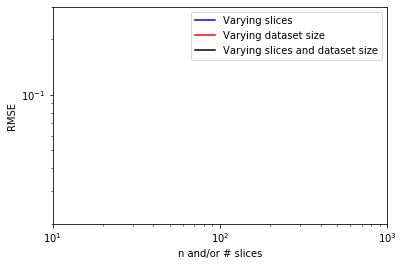

In [ ]:
#Best estimate available for the true value of the SMI (10*n datapoints, n*nmc slices)
mn = np.mean(val0[:,-1])

#Plot results showing RMSE to this estmated true value
plt.loglog(ns, np.sqrt(np.sum((np.abs(val0 - mn))**2,axis=0)/nmc),'b-', label = 'Varying slices')
plt.loglog(ns, np.sqrt(np.sum((np.abs(val1 - mn))**2,axis=0)/nmc), 'r-', label = 'Varying dataset size')
plt.loglog(ns, np.sqrt(np.sum((np.abs(val2 - mn))**2,axis=0)/nmc), 'k-', label = 'Varying slices and dataset size')
plt.axis([10,n,20e-3,.3])
plt.ylabel('RMSE')
plt.xlabel('n and/or # slices')
plt.legend()
#plt.savefig('MI_convergence_d10_s1000.eps')